# Reading Face - Gender and Expression

In [1]:
import os
from time import time

import numpy as np
import pandas as pd
import cv2 
from PIL import Image
from scipy import io

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torchvision import  datasets, transforms, models, get_image_backend
from torchvision.transforms import Compose
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset

from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from matplotlib import pyplot as plt

## Dataset

In [2]:
DOWNLOAD_DATA=False

### Label Encoder

In [3]:
def one_hot_encoder(data, words=True):  
    values = np.array(data)  
    if words:
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(values) 
    else:
        integer_encoded = values
    
    #onehot_encoder = OneHotEncoder(sparse=False)
    #onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    
    return integer_encoded

### IMDB

**Download And Extract**

In [4]:
if DOWNLOAD_DATA:
    """ Download """
    !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_meta.tar
    !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

    """ Extract """
    !tar -xf imdb_meta.tar
    !tar -xf imdb_crop.tar

**IMDB Class**

In [5]:
class IMDB(object):
    """
    1.0 MALE
    0.0 FEMALE
    """
    def __init__(self, path):  
        self.images_paths = []
        self.labels = []
        self.collector(path)
        self.labels = one_hot_encoder(self.labels, words=False)
    
    def collector(self, paths):
        imdb, images_data_path = paths
        imdb = io.loadmat(imdb)
        labels = imdb['imdb'][0][0][3][0]
        images_paths = imdb['imdb'][0][0][2][0]
        for i in range(len(images_paths)):
            images_paths[i] = os.path.join(images_data_path, images_paths[i][0])

        for i in range(len(labels)):
            if labels[i] in [0, 1] and os.path.isfile(images_paths[i]) :
              self.labels.append(labels[i])
              self.images_paths.append(images_paths[i])


In [6]:
imdb = IMDB(["/home/huanglj/database/IMDB/imdb.mat", "/home/huanglj/database/IMDB/imdb_crop"])
print("No. Images {}".format(len(imdb.images_paths)))
print("No. labels {}".format(len(imdb.labels)))

No. Images 452261
No. labels 452261


### IMFDB - Unavailable

**Download And Extract**

In [ ]:
if DOWNLOAD_DATA:
    """ Download """
    !wget http://cdn.iiit.ac.in/cdn/cvit.iiit.ac.in/projects/IMFDB/IMFDB_final.zip

    """ Extract """
    !unzip IMFDB_final.zip

**IMFDB Class**

In [ ]:
class IMFDB(object):
    def __init__(self, path):
        self.t = []
        self.images_paths = []
        self.labels = {'Expressions':[],'Illumination':[],'Pose':[],'Occlusion':[],'Age':[],'Makeup':[],'Gender':[]}
        self.labels_info = {
            'Expressions': [
                'ANGER',
                'DISGUST',
                'FEAR',
                'HAPPINESS',
                'NEUTRAL',
                'SADNESS',
                'SURPRISE',
            ],
            'Illumination': [
                'BAD',
                'HIGH',
                'MEDIUM',
            ],
            'Pose': [
                'DOWN',
                'FRONTAL',
                'LEFT',
                'RIGHT',
                'UP',
            ],
            'Occlusion': [
                'BEARD',
                'GLASSES',
                'HAIR',
                'HAND',
                'NONE',
                'ORNAMENTS',
                'OTHERS',
            ],
            'Age': [
                'CHILD',
                'MIDDLE',
                'OLD',
                'YOUNG',
            ],
            'Makeup': [
                'OVER',
                'PARTIAL',
            ],
            'Gender': [
                "Male" 
                'Female',
            ]
        }
        
        self.collect_data(path)
        self.one_hot_encoder()
        
    def collect_data(self, path):
        if not os.path.isdir(path):
            return
        if 'images' in os.listdir(path):
            if  len([t for t in os.listdir(path) if '.txt' in t]) == 1:
                self.collector(path)
            return
        for dir in os.listdir(path):
            self.collect_data(os.path.join(path,dir))
        return (self.images_paths, self.labels)

    def collector(self, path):
        x = [x for x in os.listdir(path) if '.txt' in x]
        file_path = os.path.join(path ,x[0])
        with open(file_path, 'r') as file:
           
            data = file.readlines()
            for f in data:
                f = f.split('\t')[:-1]
                f = [x.strip() for x in f]
                
                if len(f) != 17:
                    continue
                
                image_name = f[2]

                if len(image_name) < 1 :
                    continue    
                
                image_path = os.path.join(path,'images' , image_name)
                
                if not os.path.isfile(image_path):
                    continue
                    
                self.images_paths.append(image_path)
                self.labels['Makeup'].append(f[-1])
                self.labels['Pose'].append(f[-2])
                self.labels['Age'].append(f[-3])
                self.labels['Illumination'].append(f[-4])
                self.labels['Occlusion'].append(f[-5])
                self.labels['Expressions'].append(f[-6])
                self.labels['Gender'].append(f[-7])
               
    def one_hot_encoder(self):
      
        self.labels["Makeup"] = one_hot_encoder(self.labels["Makeup"])
        self.labels["Pose"] = one_hot_encoder(self.labels["Pose"])
        self.labels["Age"] = one_hot_encoder(self.labels["Age"])
        self.labels["Illumination"] = one_hot_encoder(self.labels["Illumination"])
        self.labels["Occlusion"] = one_hot_encoder(self.labels["Occlusion"])
        self.labels["Expressions"] = one_hot_encoder(self.labels["Expressions"])
        self.labels["Gender"] = one_hot_encoder(self.labels["Gender"])
      
    

In [ ]:
imfdb = IMFDB('/content/IMFDB_final')
print("No. Images {}".format(len(imfdb.images_paths)))
print("No. Models {}".format(len(imfdb.labels)))
print("No. Makeup labels {}".format(len(imfdb.labels["Makeup"])))
print("No. Pose labels {}".format(len(imfdb.labels["Pose"])))
print("No. Age labels {}".format(len(imfdb.labels["Age"])))
print("No. Illumination labels {}".format(len(imfdb.labels["Illumination"])))
print("No. Occlusion labels {}".format(len(imfdb.labels["Occlusion"])))
print("No. Expressions labels {}".format(len(imfdb.labels["Expressions"])))
print("No. Gender labels {}".format(len(imfdb.labels["Gender"])))

### WIKI

**Download And Extract**

In [7]:
if DOWNLOAD_DATA:
    """ Download """
    !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
  
    """ Extract """
    !tar -xf wiki_crop.tar

**WIKI Class**

In [8]:
class WIKI(object):
    """
    1.0 MALE
    0.0 FEMALE
    """
    def __init__(self, path):  
        self.images_paths = []
        self.labels = []
        self.collector(path)
        self.labels = one_hot_encoder(self.labels, words=False)

    def collector(self, paths):
        imdb, images_data_path = paths
        imdb = io.loadmat(imdb)
        labels = imdb['wiki'][0][0][3][0]
        images_paths = imdb['wiki'][0][0][2][0]
        for i in range(len(images_paths)):
            images_paths[i] = os.path.join(images_data_path, images_paths[i][0])

        for i in range(len(labels)):
            if labels[i] in [0, 1] and os.path.isfile(images_paths[i]) :
              self.labels.append(labels[i])
              self.images_paths.append(images_paths[i])


In [9]:
wiki = WIKI(["/home/huanglj/database/wiki_crop/wiki.mat", "/home/huanglj/database/wiki_crop"])
print("No. Images {}".format(len(wiki.images_paths)))
print("No. labels {}".format(len(wiki.labels)))

No. Images 59685
No. labels 59685


### JAFFE

**Download And Extract**

In [10]:
if DOWNLOAD_DATA:
    """ Download """
    !wget http://www.kasrl.org/jaffedbase.zip
  
    """ Extract """
    !unzip jaffedbase.zip

**JAFFE Class**

In [11]:
class JAFFE(object):
    def __init__(self, path):
      
        self.images_paths = []
        self.labels = []
        self.collector(path)
        self.labels = one_hot_encoder(self.labels)
        
    def collector(self, path):
 
        for img in os.listdir(path):
          
            if len(img.split('.')) != 4:
                continue
          
            if img.split('.')[1][:-1] == "AN":
                self.labels.append("ANGER")
            elif img.split('.')[1][:-1] == "DI":
                self.labels.append("DISGUST")
            elif img.split('.')[1][:-1] == "FE":
                self.labels.append("FEAR")
            elif img.split('.')[1][:-1] == "HA":
                self.labels.append("HAPPINESS")
            elif img.split('.')[1][:-1] == "NE":
                 self.labels.append("NEUTRAL")
            elif img.split('.')[1][:-1] == "SA":
                 self.labels.append("SADNESS")
            elif img.split('.')[1][:-1] == "SU":
                 self.labels.append("SURPRISE")
            self.images_paths.append(os.path.join(path,img))   

In [12]:
jaffe = JAFFE('/home/huanglj/database/jaffedbase')
print("No. Images {}".format(len(jaffe.images_paths)))
print("No. labels {}".format(len(jaffe.labels)))

No. Images 213
No. labels 213


### FER

In [13]:
if DOWNLOAD_DATA:
    !tar -xf "/content/drive/My Drive/data/fer2013.tar.gz"

In [14]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x


class FER(object):
    def __init__(self, path):
        self.images_paths = []
        self.labels = []
        self.collector(path)
        self.labels = one_hot_encoder(self.labels)
        
    def collector(self, path):
        data = pd.read_csv(path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        image_size = (width, height)
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'), image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        emotions = pd.get_dummies(data['emotion']).values
        emotions = np.argmax(emotions, axis=1).reshape(-1, 1)
        for i in range(len(emotions)):
            if emotions[i][0] == 4:
                emotions[i][0] = np.array(5)
            elif emotions[i][0] == 5:
                emotions[i][0] = np.array(6)
            elif emotions[i][0] == 6:
                emotions[i][0] = np.array(4)
        
        #faces = preprocess_input(faces)
        self.images_paths = faces
        self.labels = emotions


In [15]:
fer = FER('/home/huanglj/database/fer2013/fer2013.csv')
print("No. Images {}".format(len(fer.images_paths)))
print("No. labels {}".format(len(fer.labels)))

No. Images 35887
No. labels 35887


/home/huanglj/miniconda3/envs/py3-dl/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Haar Cascades

In [16]:
detector = cv2.CascadeClassifier('/home/huanglj/repo/opencv-data/haarcascades/haarcascade_frontalface_alt2.xml')

## DataLoader

In [17]:
def pil_loader(path):
    if type(path) == str:
        with open(path, 'rb') as f:  
            img = Image.open(f)
            img = img.convert('RGB')
    else:
        img = path
        img = np.array(img, dtype='uint8')
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = np.array(img, dtype='uint8')
    faces = detector.detectMultiScale(img, 1.3, 5)
    # XXX: options based on face number
    if len(faces) == 1:
        (fX, fY, fW, fH) = faces[0]
        face = img[fY:fY + fH, fX:fX + fW]
    else:
        face = img
    face = cv2.resize(face, (64, 64))
    return face

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        return pil_loader(path)

def default_loader(path):
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [18]:
class ImageDataSets(Dataset):

    def __init__(self, transform=None, image_loader=default_loader):
        self.images_paths =[]
        self.labels = []
        self.loader = image_loader
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self,indx):
        image = self.loader(self.images_paths[indx])
        label = self.labels[indx]
        if self.transform:
            image = self.transform(image)
        return image,label

## Transformation

In [20]:
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.RandomRotation(10),
                                        transforms.TenCrop((64,64)),
                                        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops]))
                                      ])
test_transforms = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.Resize((64,64)),
                                     transforms.ToTensor(),
                                     ])

## Displaying Data

In [21]:
def imshow(img):
    
    #img = ((img /2.)+0.5)*255.# 0.5 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [44]:
def displaying_data(dataiter, dic):
    # obtain one batch of training images
    images, labels = dataiter.next()
    # convert images to numpy for display
    images = images.numpy()
    
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display 20 images
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        try:
            imshow(images[idx][0])
        except:
            imshow(images[idx])

        ax.set_title(dic[int(labels[idx])])

# Network Model

## Model

In [23]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

In [24]:
class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=2,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)
            
        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)
        

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp
                            
        x+=skip
        
        return x

In [25]:
class Feature_Extractor(nn.Module):
    
    def __init__(self):
        super(Feature_Extractor, self).__init__()
        
        self.con2d_1 = nn.Conv2d(in_channels=3,out_channels=8,
                                  kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False)
        self.bn_1 = nn.BatchNorm2d(8)
        
        self.con2d_2 = nn.Conv2d(in_channels=8,out_channels=8,
                                  kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False)
        self.bn_2 = nn.BatchNorm2d(8)
        self.block_1 = Block(in_filters=8, out_filters=16,reps=2)
        self.block_2 = Block(in_filters=16, out_filters=32,reps=2)
        self.block_3 = Block(in_filters=32, out_filters=64,reps=2)
        self.block_4 = Block(in_filters=64, out_filters=128,reps=2)

        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        x = self.con2d_1(x)
        x = self.bn_1(x)
        x = self.relu(x)
        
        x = self.con2d_2(x)
        x = self.bn_2(x)
        x = self.relu(x)
        
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        
        return x

In [26]:
class Classifier(nn.Module):
    
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        
        self.conv2d_f = nn.Conv2d(in_channels=128, out_channels=num_classes,
                                  kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.glob_avg_bool = nn.AvgPool2d(kernel_size=(13, 13))
        
        self.softmax = nn.Softmax()

        
    def forward(self, x):
        x = self.conv2d_f(x)
        x = self.glob_avg_bool(x)
#         x = self.softmax(x)
        
        return x

In [27]:
class Model(nn.Module):
    
    def __init__(self,num_classes):
        super(Model, self).__init__()
        
        self.feature_extractor = Feature_Extractor()
        self.classifier = Classifier(num_classes)
    
    def forward(self,x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        
        return x

# Workers

## Train

### Loss Function  

In [28]:
criterion = nn.CrossEntropyLoss()

### Trian Function

In [29]:
def train(model, train_loader, valid_loader,n_epochs, optimizer, loss_function, model_file):
    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []
    min_valid_loss =  0.504712#np.Inf epoch 4
    for e in range(1,n_epochs+1):
  
        epoch_start = time()
        batch_number = 0

        train_loss = 0
        train_acc = 0
        batch_start = time()
        model.train()   
        for x,y in train_loader:
            batch_number += 1
            if torch.cuda.is_available() :
                x, y = x.cuda(), y.cuda()
            y = y.long()
#             print(x.shape)

            optimizer.zero_grad()
            bs, ncrops, c, h, w = x.size()
            result = model(x.view(-1, c, h, w)) # fuse batch size and ncrops
            y_ = result.view(bs, ncrops, -1).mean(1)
#             y_ = model.forward(x)

#             loss, y_,y= loss_function(y_.cpu(),y.cpu())
#             y = torch.argmax(y,dim=1)

            y = y.squeeze()
            y_ = y_.view((y_.shape[0],y_.shape[1])) 
#             print(y.shape,y_.shape)
            loss = criterion(y_,y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            ps = torch.exp(y_)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor))
            delay = time()-batch_start
#             print("batch size : {}\nbatch per total no of batches : {}/{} \
#             \ntrain batch finished : {:.3f} % \ntime left : {}s \ndelay : {}s \
#             \nloss : {}\n\n".format(len(x), batch_number, len(train_loader),
#             batch_number/len(train_loader) *100., delay * (len(train_loader)-\
#             batch_number), delay, loss.item()))
            
            batch_start = time()
        
        valid_loss = 0
        valid_acc = 0
        model.eval()

        with torch.no_grad():
            batch_number = 0
            batch_start = time()
            acc = 0
            for x,y in valid_loader:
                batch_number += 1
                if torch.cuda.is_available() :
                    x, y = x.cuda(), y.cuda()
                y = y.long()
#                 x = x.squeeze()
#                 y = y.squeeze()
                bs, ncrops, c, h, w = x.size()
                result = model(x.view(-1, c, h, w)) # fuse batch size and ncrops
                y_ = result.view(bs, ncrops, -1).mean(1)
#                 y_ = model.forward(x)

#                 loss, y_,y= loss_function(y_.cpu(),y.cpu())
                y = y.squeeze()
                y_ = y_.view((y_.shape[0],y_.shape[1]))   
                loss = criterion(y_,y)
    
                valid_loss += loss.item()
                
               
                ps = torch.exp(y_)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y.view(*top_class.shape)
                valid_acc += torch.mean(equals.type(torch.FloatTensor))
                delay = time()-batch_start
      
#                 print("batch size : {}\nbatch per total no of batches : {}/{} \
#                 \ntrain batch finished : {:.3f} % \ntime lift : {} s\
#                 \ndelay : {}s \nloss : {}\n\n".format(len(x),
#                 batch_number, len(valid_loader), batch_number/len(valid_loader)\
#                       *100., delay * (len(valid_loader)-batch_number), delay,\
#                                                       loss.item()))
                batch_start = time()
                

        train_loss /= len(train_loader)     
        train_acc /= len(train_loader)  

        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        if min_valid_loss > valid_loss:
            print ('Validation loss decreased ({:.6f} --> {:.6f}). \
            Saving model ...\n'.format(min_valid_loss, valid_loss))
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), model_file)
        
        delay = time() - epoch_start


        print("Epoch : {} \nTrain Finished : {:.3f} %\nTime Left : {:.3f} s\
        \nTraining Loss : {:.6f} \nValidation Loss : {:.6f} \nTrain Accuracy :\
        {:.3f} %\nValidation Accuracy : {:.6f} %\nDelay : {:.6f} s \n\n".format(
            e,e / n_epochs * 100., delay * (n_epochs - e) ,train_loss, valid_loss
            ,train_acc * 100.,valid_acc * 100.,delay))
        
    return train_losses, train_accs, valid_losses, valid_accs




## Displaying Graph

In [30]:
def display_graph(train_losses, valid_losses, train_accs, valid_accs):
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.plot(train_accs, label='Train accuracy')
    plt.plot(valid_accs, label='Validation accuracy')
    plt.legend(frameon=False)

## Test

In [31]:
def test(model, test_loader, loss_function):
   
    test_loss = 0
    test_acc = 0
    
    model.eval()

    with torch.no_grad():

        batch_number = 0
        batch_start = time()
        for x,y in test_loader:
            batch_number += 1
            y = y.long()
            if torch.cuda.is_available() :
                x, y = x.cuda(), y.cuda()
#             x = x.squeeze()
#             y = y.squeeze()
            y_ = model.forward(x)
  
            y = y.squeeze()
            y_ = y_.view((y_.shape[0],y_.shape[1]))   
            loss = criterion(y_,y)
            test_loss += loss.item()

            ps = torch.exp(y_)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y.view(*top_class.shape)

            test_acc += torch.mean(equals.type(torch.FloatTensor))
            delay = time()-batch_start

            print("batch size : {}\nbatch per total no of batches : {}/{} \
            \ntrain batch finished : {:.3f} % \ntime lift : {} s\
            \ndelay : {}s \nloss : {}\n\n".format(len(x),
            batch_number, len(test_loader), batch_number/len(test_loader)\
                  *100., delay * (len(test_loader)-batch_number), delay,\
                                                  loss.item()))
            batch_start = time()
            
    return test_loss/len(test_loader), test_acc/len(test_loader)

## Confusion Matrix

In [32]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Predict

In [33]:
def predict(model, data, data_mapping):
    predictions = model(data)
    for predict in predictions:
        ps = torch.exp(predict)
        top_p, top_class = ps.topk(1, dim=1)
        print(top_p)

# Models

## Gender

### Data

**Loading Data**

In [34]:
gender_images_paths = imdb.images_paths
gender_labels =   imdb.labels

In [45]:
#gender_images_paths = imfdb.images_paths + imdb.images_paths + wiki.images_paths
#gender_labels =  np.array(imfdb.labels["Gender"].tolist() + imdb.labels.tolist() + wiki.labels.tolist())
gender_images_paths = imdb.images_paths + wiki.images_paths
gender_labels =  np.array(imdb.labels.tolist() + wiki.labels.tolist())

In [ ]:
# gender_images_paths = wiki.images_paths[:3000]
# gender_labels =  np.array(wiki.labels.tolist())[:3000]

In [46]:
print("No. images paths {}".format(len(gender_images_paths)))
print("No. labels {}".format(len(gender_labels)))
assert len(gender_labels) == len(gender_images_paths)

No. images paths 511946
No. labels 511946


**Shuffle & Spliting Data** 

In [47]:
valid_size = 0.02
test_size = 0.02

train_dataset = ImageDataSets(train_transforms)
train_dataset.images_paths = gender_images_paths
train_dataset.labels = gender_labels

test_dataset = ImageDataSets(test_transforms)
test_dataset.images_paths = gender_images_paths
test_dataset.labels = gender_labels

train_size = len(train_dataset)

indices = list(range(train_size))
np.random.shuffle(indices)

valid_split_size = int(valid_size * train_size)
test_split_size = int(test_size * train_size)

train_indices, test_indices, valid_indices = indices[test_split_size + valid_split_size:], indices[:test_split_size], indices[test_split_size:test_split_size + valid_split_size]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 32

**Data Loaders**

In [48]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
valid_loader = DataLoader(train_dataset,batch_size=batch_size,sampler=valid_sampler)
test_loader = DataLoader(test_dataset,batch_size=batch_size,sampler=valid_sampler)

**Displaying Data**

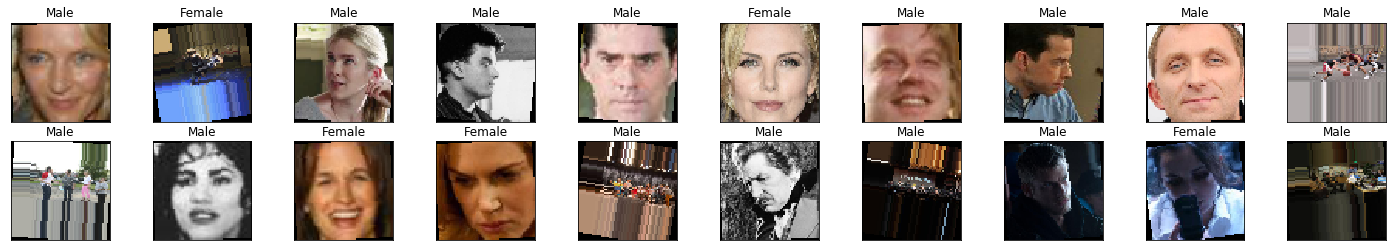

In [50]:
dataiter = iter(train_loader)
displaying_data(dataiter,{1:'Male',0:"Female"})

In [ ]:
dataiter = iter(valid_loader)
displaying_data(dataiter,{1:'Male',0:"Female"})

In [ ]:
dataiter = iter(test_loader)
displaying_data(dataiter,{1:'Male',0:"Female"})

### Loss Function

In [ ]:
def loss_fun(y_, y):
    y = torch.argmax(y,dim=1)
    y_ = y_.view((y_.shape[0],y_.shape[1]))
    loss = nn.CrossEntropyLoss()(y_.cpu(),y.cpu())
    
    return loss,y_,y

### Define Model

In [ ]:
model = Model(2)
model.load_state_dict(torch.load("/content/drive/My Drive/Models/gender.pth"))
model.cuda();

### Define Optimizer

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Train

**Path for saving model**

In [ ]:
model_file = "/content/drive/My Drive/Models/gender.pth"

In [ ]:
train_losses, train_accs, valid_losses, valid_accs = train(model, train_loader, valid_loader, 25, optimizer, None, model_file)

### Displaying Graph

In [ ]:
display_graph(train_losses, valid_losses, train_accs, valid_accs)

### Test

In [ ]:
test_loss, test_acc# = test(model, test_loader, loss_fun)

### Confusion Matrix

In [ ]:
images, labels = iter(valid_loader).next()

y_true = labels
y_pred = model(images.cuda())

y_true = torch.argmax(y_true,dim=1)
y_pred = y_pred.view((y_pred.shape[0],y_pred.shape[1]))
y_pred = torch.argmax(y_pred,dim=1)


In [ ]:
plot_confusion_matrix(y_true.cpu(), y_pred.cpu(), np.array(['female','male']),
                          normalize=False,
                          title='None',
                          cmap=plt.cm.Blues)

### Predict

In [ ]:
predict(model, iter(valid_loader).next()[0].cuda(), {1:'Male',0:"Female"})

## Emotion

### Data

**Loading Data**

In [ ]:
emotion_images_paths = fer.images_paths
emotion_labels = fer.labels

In [ ]:
# emotion_images_paths = imfdb.images_paths + jaffe.images_paths 
# emotion_labels = np.array(imfdb.labels["Expressions"].tolist() + jaffe.labels.tolist())

In [ ]:
print("No. images paths {}".format(len(emotion_images_paths)))
print("No. labels {}".format(len(emotion_labels)))
assert len(emotion_labels) == len(emotion_images_paths)

**Shuffle & Spliting Data** 

In [ ]:
valid_size = 0.03
test_size = 0.03

train_dataset = ImageDataSets(train_transforms)
train_dataset.images_paths = emotion_images_paths
train_dataset.labels = emotion_labels

test_dataset = ImageDataSets(test_transforms)
test_dataset.images_paths = emotion_images_paths
test_dataset.labels = emotion_labels

train_size = len(train_dataset)

indices = list(range(train_size))
np.random.shuffle(indices)

valid_split_size = int(valid_size * train_size)
test_split_size = int(test_size * train_size)

train_indices, test_indices, valid_indices = indices[test_split_size + valid_split_size:], indices[:test_split_size], indices[test_split_size:test_split_size + valid_split_size]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 32

**Data Loaders**

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
valid_loader = DataLoader(train_dataset,batch_size=batch_size,sampler=valid_sampler)
test_loader = DataLoader(test_dataset,batch_size=batch_size,sampler=valid_sampler)

**Displaying Data**

In [ ]:
dataiter = iter(train_loader)
displaying_data(dataiter, ['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'NEUTRAL', 'SADNESS', 'SURPRISE'])

In [ ]:
dataiter = iter(valid_loader)
displaying_data(dataiter,['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'NEUTRAL', 'SADNESS', 'SURPRISE'])

In [ ]:
dataiter = iter(test_loader)
displaying_data(dataiter,['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'NEUTRAL', 'SADNESS', 'SURPRISE'])

### Define Model


In [ ]:
model = Model(7)
model.load_state_dict(torch.load("/content/drive/My Drive/Models/emotion.pth"))
model.cuda();

### Define Optimizer

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train

**Path for saving model**

In [ ]:
model_file = "/content/drive/My Drive/Models/emotion.pth"

In [ ]:
train_losses, train_accs, valid_losses, valid_accs = train(model, train_loader, valid_loader, 10, optimizer, None, model_file)

### Displaying Graph

In [ ]:
display_graph(train_losses, valid_losses, train_accs, valid_accs)

### Test

In [ ]:
test(model, test_loader, None)

### Confusion Matrix

In [ ]:
images, labels = iter(test_loader).next()

In [ ]:
y_true = labels
bs, ncrops, c, h, w = images.size()
result = model(images.view(-1, c, h, w).cuda()) # fuse batch size and ncrops
y_pred = result.view(bs, ncrops, -1).mean(1)
# y_pred = model(images.cuda())

y_true = torch.argmax(y_true,dim=1)
y_pred = y_pred.view((y_pred.shape[0],y_pred.shape[1]))
y_pred = torch.argmax(y_pred,dim=1)

In [ ]:
plot_confusion_matrix(y_true.cpu(), y_pred.cpu(), np.array([ 'ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'NEUTRAL', 'SADNESS', 'SURPRISE', ]),
                          normalize=False,
                          title='None',
                          cmap=plt.cm.Blues)

## Illumination, Pose, Occlusion, Age and Makeup

### Data

**Loading Data**

In [ ]:
multiplemodels_images_paths = imfdb.images_paths
multiplemodels_labels = np.array(list(zip(imfdb.labels["Illumination"].tolist(), imfdb.labels["Pose"].tolist(), imfdb.labels["Occlusion"].tolist(), imfdb.labels["Age"].tolist(), imfdb.labels["Makeup"].tolist())))

In [ ]:
print("No. images paths {}".format(len(multiplemodels_images_paths)))
print("No. labels {}".format(len(multiplemodels_labels)))
assert len(multiplemodels_labels) == len(multiplemodels_images_paths)

**Shuffle & Spliting Data** 

In [ ]:
valid_size = 0.1
test_size = 0.1

train_dataset = ImageDataSets(train_transforms)
train_dataset.images_paths = multiplemodels_images_paths
train_dataset.labels = multiplemodels_labels

test_dataset = ImageDataSets(test_transforms)
test_dataset.images_paths = multiplemodels_images_paths
test_dataset.labels = multiplemodels_labels

train_size = len(train_dataset)

indices = list(range(train_size))
np.random.shuffle(indices)

valid_split_size = int(valid_size * train_size)
test_split_size = int(test_size * train_size)

train_indices, test_indices, valid_indices = indices[test_split_size + valid_split_size:], indices[:test_split_size], indices[test_split_size:test_split_size + valid_split_size]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 32

**Data Loaders**

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
valid_loader = DataLoader(train_dataset,batch_size=batch_size,sampler=valid_sampler)
test_loader = DataLoader(test_dataset,batch_size=batch_size,sampler=valid_sampler)

**Displaying Data**

In [ ]:
def displaying_data(dataiter, dic,i):
    # obtain one batch of training images
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display 20 images
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        try:
            imshow(images[idx][0])
        except:
            imshow(images[idx])

        ax.set_title(dic[int(labels[idx][i])])

In [ ]:
dataiter = iter(train_loader)
displaying_data(dataiter, ['BAD','HIGH','MEDIUM'],0)
displaying_data(dataiter, ['DOWN','FRONTAL','LEFT','RIGHT','UP'],1)
displaying_data(dataiter, ['BEARD','GLASSES','HAIR','HAND','NONE','ORNAMENTS','OTHERS',],2)
displaying_data(dataiter, ['Middle', 'Old', 'Young'],3)
displaying_data(dataiter, ['OVER','PARTIAL'],4)

In [ ]:
dataiter = iter(valid_loader)
displaying_data(dataiter,['BAD','HIGH','MEDIUM'],0)
displaying_data(dataiter,['DOWN','FRONTAL','LEFT','RIGHT','UP'],1)
displaying_data(dataiter,['BEARD','GLASSES','HAIR','HAND','NONE','ORNAMENTS','OTHERS',],2)
displaying_data(dataiter,['Middle', 'Old', 'Young'],3)
displaying_data(dataiter, ['OVER','PARTIAL'],4)

In [ ]:
dataiter = iter(test_loader)
displaying_data(dataiter,['BAD','HIGH','MEDIUM'],0)
displaying_data(dataiter,['DOWN','FRONTAL','LEFT','RIGHT','UP'],1)
displaying_data(dataiter,['BEARD','GLASSES','HAIR','HAND','NONE','ORNAMENTS','OTHERS',],2)
displaying_data(dataiter,['Middle', 'Old', 'Young'],3)
displaying_data(dataiter, ['OVER','PARTIAL'],4)

### Define Model

In [ ]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.feature_extractor = Feature_Extractor()
        self.illumination = Classifier(3)
        self.pose = Classifier(5)
        self.occlusion = Classifier(7)
        self.age = Classifier(3)
        self.makeup = Classifier(2)
    
    def forward(self,x):
        
        x = self.feature_extractor(x)
        
#         feature_extractor = self.feature_extractor(x)
        illumination = self.illumination(x)
        pose = self.pose(x)
        occlusion = self.occlusion(x) 
        age = self.age(x)
        makeup = self.makeup(x) 

        return illumination, pose, occlusion, age, makeup

In [ ]:
model = Model()
model.load_state_dict(torch.load("/content/drive/My Drive/Models/multiplemodels.pth"))

model.cuda();

### Define Optimizer

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Path for saving model**

In [ ]:
model_file = "/content/drive/My Drive/Models/multiplemodels.pth"

### Train

In [ ]:
def train(model, train_loader, valid_loader,n_epochs, optimizer, loss_function, model_file):
    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []
    min_valid_loss =  np.Inf
    for e in range(1,n_epochs+1):
  
        epoch_start = time()
        batch_number = 0

        train_loss = 0
        train_acc = 0
        batch_start = time()
        model.train()   
        for x,y in train_loader:
            batch_number += 1
            if torch.cuda.is_available() :
                x, y = x.cuda(), y.cuda()
            optimizer.zero_grad()
            bs, ncrops, c, h, w = x.size()
            result = model(x.view(-1, c, h, w)) 
            illumination, pose, occlusion, age, makeup = result

            illumination = illumination.view(bs, ncrops, -1).mean(1)#view((illumination.shape[0],illumination.shape[1])) 
            pose = pose.view(bs, ncrops, -1).mean(1)#.view((pose.shape[0],pose.shape[1])) 
            occlusion = occlusion.view(bs, ncrops, -1).mean(1)#.view((occlusion.shape[0],occlusion.shape[1])) 
            age = age.view(bs, ncrops, -1).mean(1)#.view((age.shape[0],age.shape[1])) 
            makeup = makeup.view(bs, ncrops, -1).mean(1)#.view((makeup.shape[0],makeup.shape[1])) 

            
#             y = y.squeeze()
#             print(y)

            y_illumination, y_pose, y_occlusion, y_age, y_makeup = y[:,0].squeeze(),y[:,1].squeeze(),y[:,2].squeeze(),y[:,3].squeeze(),y[:,4].squeeze()
        
            loss_illumination = criterion(illumination,y_illumination)
            loss_pose = criterion(pose,y_pose)
            loss_occlusion = criterion(occlusion,y_occlusion)
            loss_age = criterion(age,y_age)
            loss_makeup = criterion(makeup,y_makeup)
            
            loss = loss_illumination + loss_pose + loss_occlusion + loss_age +loss_makeup
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            ps = torch.exp(illumination)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y_illumination.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor))
            
            ps = torch.exp(pose)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y_pose.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor))
            
            ps = torch.exp(occlusion)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y_occlusion.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor))
            
            ps = torch.exp(age)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y_age.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor))
            
            ps = torch.exp(makeup)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y_makeup.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor))
#             print(illumination.shape,y_illumination.shape)
            
            
            
            
            delay = time()-batch_start
#             print("batch size : {}\nbatch per total no of batches : {}/{} \
#             \ntrain batch finished : {:.3f} % \ntime left : {}s \ndelay : {}s \
#             \nloss : {}\n\n".format(len(x), batch_number, len(train_loader),
#             batch_number/len(train_loader) *100., delay * (len(train_loader)-\
#             batch_number), delay, loss.item()))
            
            batch_start = time()
#         print('aaaaaaa\n\n\n')

        valid_loss = 0
        valid_acc = 0
        model.eval()

        with torch.no_grad():
            batch_number = 0
            batch_start = time()
            acc = 0
            for x,y in valid_loader:
                batch_number += 1
                if torch.cuda.is_available() :
                    x, y = x.cuda(), y.cuda()
#                 x = x.squeeze()
#                 y = y.squeeze()

                bs, ncrops, c, h, w = x.size()
                result = model(x.view(-1, c, h, w)) 
                illumination, pose, occlusion, age, makeup = result

                illumination = illumination.view(bs, ncrops, -1).mean(1)#view((illumination.shape[0],illumination.shape[1])) 
                pose = pose.view(bs, ncrops, -1).mean(1)#.view((pose.shape[0],pose.shape[1])) 
                occlusion = occlusion.view(bs, ncrops, -1).mean(1)#.view((occlusion.shape[0],occlusion.shape[1])) 
                age = age.view(bs, ncrops, -1).mean(1)#.view((age.shape[0],age.shape[1])) 
                makeup = makeup.view(bs, ncrops, -1).mean(1)#.view((makeup.shape[0],makeup.shape[1])) 


    #             y = y.squeeze()
    #             print(y)

                y_illumination, y_pose, y_occlusion, y_age, y_makeup = y[:,0].squeeze(),y[:,1].squeeze(),y[:,2].squeeze(),y[:,3].squeeze(),y[:,4].squeeze()

                loss_illumination = criterion(illumination,y_illumination)
                loss_pose = criterion(pose,y_pose)
                loss_occlusion = criterion(occlusion,y_occlusion)
                loss_age = criterion(age,y_age)
                loss_makeup = criterion(makeup,y_makeup)

                loss = loss_illumination + loss_pose + loss_occlusion + loss_age +loss_makeup

                
                valid_loss += loss.item()

                ps = torch.exp(illumination)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y_illumination.view(*top_class.shape)
                valid_acc += torch.mean(equals.type(torch.FloatTensor))

                ps = torch.exp(pose)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y_pose.view(*top_class.shape)
                valid_acc += torch.mean(equals.type(torch.FloatTensor))

                ps = torch.exp(occlusion)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y_occlusion.view(*top_class.shape)
                valid_acc += torch.mean(equals.type(torch.FloatTensor))

                ps = torch.exp(age)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y_age.view(*top_class.shape)
                valid_acc += torch.mean(equals.type(torch.FloatTensor))

                ps = torch.exp(makeup)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y_makeup.view(*top_class.shape)
                valid_acc += torch.mean(equals.type(torch.FloatTensor))

                delay = time()-batch_start
      
#                 print("batch size : {}\nbatch per total no of batches : {}/{} \
#                 \ntrain batch finished : {:.3f} % \ntime lift : {} s\
#                 \ndelay : {}s \nloss : {}\n\n".format(len(x),
#                 batch_number, len(valid_loader), batch_number/len(valid_loader)\
#                       *100., delay * (len(valid_loader)-batch_number), delay,\
#                                                       loss.item()))
                batch_start = time()
                

        train_loss /= (len(train_loader) * 5.)     
        train_acc /= (len(train_loader)  * 5.)

        valid_loss /= (len(valid_loader) * 5.)
        valid_acc /= (len(valid_loader) * 5.)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        if min_valid_loss > valid_loss:
            print ('Validation loss decreased ({:.6f} --> {:.6f}). \
            Saving model ...\n'.format(min_valid_loss, valid_loss))
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), model_file)
        
        delay = time() - epoch_start


        print("Epoch : {} \nTrain Finished : {:.3f} %\nTime Left : {:.3f} s\
        \nTraining Loss : {:.6f} \nValidation Loss : {:.6f} \nTrain Accuracy :\
        {:.3f} %\nValidation Accuracy : {:.6f} %\nDelay : {:.6f} s \n\n".format(
            e,e / n_epochs * 100., delay * (n_epochs - e) ,train_loss, valid_loss
            ,train_acc * 100.,valid_acc * 100.,delay))
        
    return train_losses, train_accs, valid_losses, valid_accs




In [ ]:
train_losses, train_accs, valid_losses, valid_accs = train(model, train_loader, valid_loader, 25, optimizer, None, model_file)

### Displaying Graph


In [ ]:
display_graph(train_losses, valid_losses, train_accs, valid_accs)

### Test

In [ ]:
def test(model, test_loader):
   
    test_loss = 0
    test_acc = 0
    model.eval()

    with torch.no_grad():
        batch_number = 0
        batch_start = time()
        acc = 0
        for x,y in test_loader:
            batch_number += 1
            if torch.cuda.is_available() :
                x, y = x.cuda(), y.cuda()

            bs, c, h, w = x.size()
            result = model(x) 
            illumination, pose, occlusion, age, makeup = result

            illumination = illumination.view(bs, -1) 
            pose = pose.view(bs, -1)
            occlusion = occlusion.view(bs, -1)
            age = age.view(bs, -1)
            makeup = makeup.view(bs, -1)

            y_illumination, y_pose, y_occlusion, y_age, y_makeup = y[:,0].squeeze(),y[:,1].squeeze(),y[:,2].squeeze(),y[:,3].squeeze(),y[:,4].squeeze()
            loss_illumination = criterion(illumination,y_illumination)
            loss_pose = criterion(pose,y_pose)
            loss_occlusion = criterion(occlusion,y_occlusion)
            loss_age = criterion(age,y_age)
            loss_makeup = criterion(makeup,y_makeup)

            loss = loss_illumination + loss_pose + loss_occlusion + loss_age +loss_makeup


            test_loss += loss.item()

            ps = torch.exp(illumination)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y_illumination.view(*top_class.shape)
            test_acc += torch.mean(equals.type(torch.FloatTensor))

            ps = torch.exp(pose)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y_pose.view(*top_class.shape)
            test_acc += torch.mean(equals.type(torch.FloatTensor))

            ps = torch.exp(occlusion)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y_occlusion.view(*top_class.shape)
            test_acc += torch.mean(equals.type(torch.FloatTensor))

            ps = torch.exp(age)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y_age.view(*top_class.shape)
            test_acc += torch.mean(equals.type(torch.FloatTensor))

            ps = torch.exp(makeup)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y_makeup.view(*top_class.shape)
            test_acc += torch.mean(equals.type(torch.FloatTensor))

            batch_start = time()
            
    return test_loss/len(test_loader), test_acc/(len(test_loader)*5)

In [ ]:
test(model, test_loader)